In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [4]:
from implementations import *

### Data pre-processing 

In [5]:
# remove categorical data
tX = np.delete(tX, 22, axis=1)
# keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX, degree = 1, cutoff = 0.7, 
                      imputation = impute_median, interaction = False)
# standarize the data
rmX = np.append(rmX, 22)
tX = np.apply_along_axis(standardize, 1, tX)
#y = y[0:500000]
#tX = tX[0:500000, :]
y = np.where(y==-1, 0, y)
print(y)

[1. 0. 0. ... 1. 0. 0.]


In [6]:
print(tX.shape)
print(rmX)

(250000, 23)
[ 4  5  6 12 25 26 27 22]


### Exploratory analysis

### Feature processing

**Least squares**

In [7]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[-7.59283089 19.6694143  19.39821666 19.35518478 19.62639834 28.63972958
 19.53006013  9.74944854 16.29645991 20.77669879 29.93140738 19.60364672
 19.57699065 29.79115422 19.56696225 19.60787189 19.70600927 19.56557262
 19.62541216 19.67129904 19.59251008 19.55347643 29.4901593 ]

mse=0.08499426980625849


**Least squares with Gradient Descent**

In [8]:
#define parameters

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

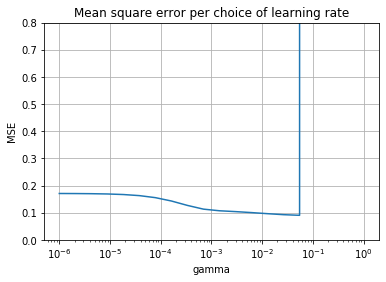

In [9]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [10]:
idx = np.nanargmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

w* =[-0.00691905  0.06815533 -0.21071341  0.00440407  0.04080694 -0.00433785
 -0.0327805   0.08147202 -0.01109581 -0.00181672  0.10617811 -0.00658096
 -0.00692606 -0.03297125 -0.00656471 -0.00617559 -0.01756861 -0.00643702
  0.02855037  0.03912669 -0.00649524 -0.0065453  -0.00476545]

mse=0.09083708553081768

gamma=0.05455594781168514


**Least squares with Stochastic Gradient Descent**

In [11]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = []
ws_sgd = []
for gamma in gammas:
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd.append(loss)
    ws_sgd.append(w)

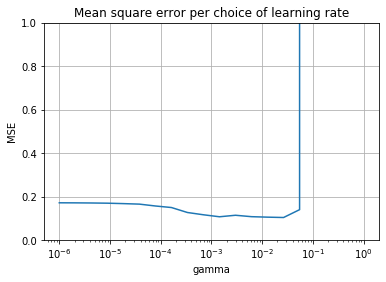

In [12]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [13]:
idx = np.nanargmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=loss_sgd, gamma=gamma_sgd ))

w* =[-0.00991052  0.03078551 -0.17130345  0.02333587 -0.01667147 -0.00766154
  0.01113745  0.11863223 -0.01360251 -0.0054107   0.1015898  -0.01191569
 -0.01031976 -0.05082104 -0.01180354 -0.01726049 -0.07350622 -0.01608877
  0.06049269  0.03607635 -0.00583577 -0.00774989  0.04781147]

mse=0.10343203207333587

gamma=0.026366508987303555


**Ridge regression**

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation and bias-variance decomposition respectively. 

As the two are interdependent, we can just run them in a loop (each cells after the others, so first the cross-validation, then biais-variance decomposition, again cross-validation, etc.) to have the best parameters. 

***Cross-validation hyperparameter selection***

In [14]:
def cross_validation_visualization(lambds, loss_tr, loss_te):
    """visualization the curves of train error and test error."""
    plt.semilogx(lambds, loss_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, loss_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

In [15]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-12, 0, 20)

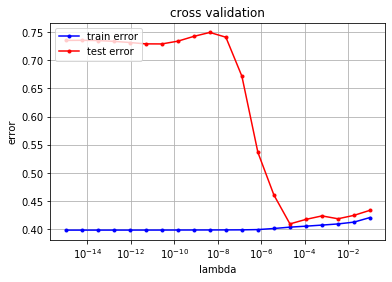

In [36]:
k_indices = build_k_indices(y, k_fold, seed)
rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, tX, k_indices, k, lambda_, degree_ri)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

In [37]:
idx = np.nanargmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

lambda* =2.06913808111479e-05

rmse train=0.40379293938524585

rmse test=0.4095477312490039


***Bias-variance decomposition for complexity determination***

In [18]:
def bias_variance_decomposition_visualization(degrees, loss_tr, loss_te):
    """visualize the bias variance decomposition."""
    loss_tr_mean = np.expand_dims(np.mean(loss_tr, axis=0), axis=0)
    loss_te_mean = np.expand_dims(np.mean(loss_te, axis=0), axis=0)
    plt.plot(degrees, loss_tr.T, 'b', linestyle="-", label='train', linewidth=0.3)
    plt.plot(degrees, loss_te.T, 'r', linestyle="-", label='test', linewidth=0.3)
    plt.plot(degrees, loss_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, loss_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")

In [19]:
ratio_train = 0.7
seeds = range(20)
degrees = range(0, 12)

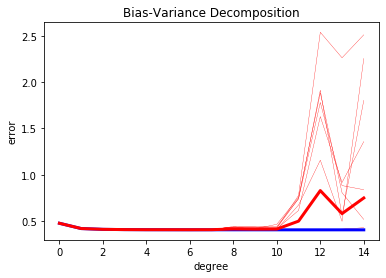

In [38]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

In [39]:
rmse_te_bv = np.array(rmse_te_bv)
rmse_tr_bv = np.array(rmse_tr_bv)

idx = np.nanargmin(np.mean(rmse_te_bv-rmse_tr_bv, axis=1))

degree_ri = degrees[idx]

print("degree* ={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx].mean(), rmse_te=rmse_te_bv[idx].mean()))

degree* =10

rmse train=0.41046086990312103

rmse test=0.40925037824742755


In [45]:
tX_poly = build_poly(tX, degree_ri)
            
w_ri, mse_ri = ridge_regression(y, tX_poly, lambda_ri)

print("final w* shape ={w}\n\nfinal degree* ={degree}\n\nfinal lambda*={lambda_}\n\nmse={loss}".format(w=w_ri.shape, \
            degree=degree_ri, lambda_=lambda_ri, loss = mse_ri))

final w* shape =(231,)

final degree* =10

final lambda*=2.06913808111479e-05

mse=0.08153707366101348


**Logistic regression**

In [22]:
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -2, 20)

In [23]:
losses_lr = []
ws_lr = []
for gamma in gammas:
    (w, loss) = logistic_regression(y, tX, initial_w, max_iters, gamma)
    losses_lr.append(loss)
    ws_lr.append(w)

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:54: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


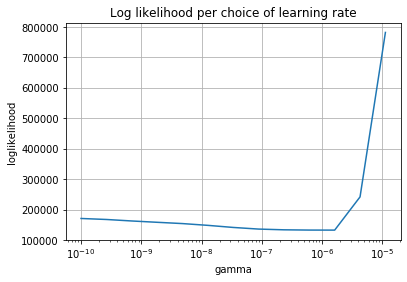

In [35]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [25]:
idx = np.nanargmin(losses_lr)

loss_lr = losses_lr[idx]
w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=loss_lr, gamma = gamma_lr))

w* =[ 0.043593    0.31880174 -1.48874813 -0.64843491  0.15602125  0.22885727
 -0.31536108  0.478765   -0.02901833  0.29718287  1.30660467  0.08014759
  0.0590694  -0.17063861  0.08045492  0.10044102 -0.01058024  0.07019087
 -0.14956618 -0.09690102  0.08570821  0.08613393 -0.48272322]

loglikelihood loss=132368.13104854123

gamma=1.6237767391887209e-06


**Regularized logistic regression**

In [26]:
initial_w = np.zeros(tX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -2, 20)
lambda_rlr =lambda_ri

In [27]:
losses_rlr = []
ws_rlr = []
for gamma in gammas:
    (w, loss) = reg_logistic_regression(y, tX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr.append(loss)
    ws_rlr.append(w)

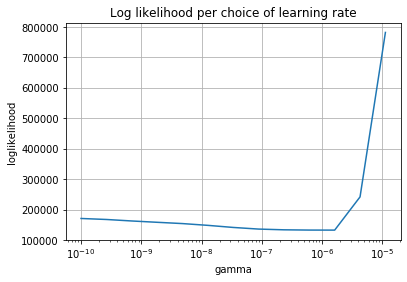

In [34]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [29]:
idx = np.nanargmin(losses_rlr)

loss_rlr = losses_rlr[idx]
w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=loss_rlr, gamma = gamma_rlr))

w* =[ 0.043593    0.31880174 -1.48874813 -0.64843491  0.15602125  0.22885727
 -0.31536108  0.478765   -0.02901833  0.29718287  1.30660467  0.08014759
  0.0590694  -0.17063861  0.08045492  0.10044102 -0.01058024  0.07019087
 -0.14956618 -0.09690102  0.08570821  0.08613393 -0.48272322]

loglikelihood loss=132368.13104854123

gamma=1.6237767391887209e-06


***Cross-validation hyperparameter selection***

In [30]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-15, 0, 20)
ratio_train = 0.7
max_iters = 1000
seeds = range(20)
degrees = range(0, 15)
initial_w = np.zeros(tX.shape[1])

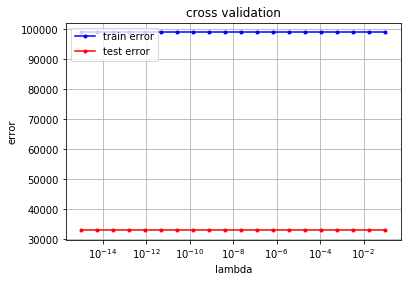

In [31]:
k_indices = build_k_indices(y, k_fold, seed)

loss_tr_cv = []
loss_te_cv = []

for lambda_ in  lambdas:
    log_tr = []
    log_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation_log(y, tX, k_indices, k, lambda_, degree_rlr, initial_w, max_iters, gamma_rlr)
        log_tr.append(loss_tr)
        log_te.append(loss_te)
    loss_tr_cv.append(np.mean(log_tr))
    loss_te_cv.append(np.mean(log_te))
cross_validation_visualization(lambdas, loss_tr_cv, loss_te_cv)

In [32]:
idx = np.nanargmin(loss_te_cv)
lambda_rlr = lambdas[idx]

print("lambda* ={lambda_}\n\nloglikelihood train={log_tr}\n\nloglikelihood test={log_te}".format(
    lambda_=lambda_rlr, log_tr=loss_tr_cv[idx], log_te=loss_te_cv[idx]))

lambda* =1e-15

loglikelihood train=98910.93785901717

loglikelihood test=32974.24872742639


***Bias-variance decomposition for complexity determination***

In [33]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        

    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

KeyboardInterrupt: 

In [ ]:
loss_te_bv = np.array(loss_te_bv)
loss_tr_bv = np.array(loss_tr_bv)

idx = np.nanargmin(np.mean(loss_te_bv-loss_tr_bv, axis=1))

degree_ri = degrees[idx]

print("degree* ={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_bv[idx].mean(), rmse_te=loss_te_bv[idx].mean()))

### Overfitting vs Underfitting

### Methods application and visualization

## Generate predictions and save ouput in csv format for submission:

In [48]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [53]:
weights = w_ri
#weights = np.insert(weights, rmX, 0, axis = 0)

tX_test = np.delete(tX_test, rmX, axis=1)
# keep only columns that do not have too much missing data
tX, rmX = train_data_formatting(tX_test, degree = 10, cutoff = 1.0, 
                      imputation = impute_median, interaction = False)
tX_test = np.apply_along_axis(standardize, 1, tX_test)

In [54]:
OUTPUT_PATH = '../data/sample-submission.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

ValueError: shapes (568238,22) and (231,) not aligned: 22 (dim 1) != 231 (dim 0)